In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
import torch

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [3]:
from dataloader import *
train_data, train_label, test_data, test_label = read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


# Utils

In [4]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        if train:
            self.xs = train_data
            self.ys = train_label
        else:
            self.xs = test_data
            self.ys = test_label
        
    def __len__(self):
        return len(self.ys)

    def __getitem__(self, idx):
        return (self.xs[idx], self.ys[idx])

In [5]:
def num_of_correct(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct, total

def compute_test_accuracy(net, test_data, test_label):
    inputs = torch.from_numpy(test_data).type(TensorInputType).to(device)
    labels = torch.from_numpy(test_label).type(TensorLabelType).to(device)

    net.eval()
    outputs = net(inputs)
    
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [6]:
def plot_history(history, model_name=''):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(history['train_acc'], label='Train(%s)'%model_name)
    plt.plot(history['val_acc'], label='Validation(%s)'%model_name)
    plt.title('Accuracy Trend(%s)'%model_name), plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.plot(history['train_loss'], label='Train(%s)'%model_name)
    plt.plot(history['val_loss'], label='Validation(%s)'%model_name)
    plt.title('Loss Trend(%s)'%model_name), plt.legend(loc='best')

In [7]:
def plot_historys(historys, model_names):
    plt.figure(figsize=(10,5))
    colors = [('salmon', 'red') , ('lightblue', 'blue'), ('lightgreen', 'green')]
    plt.subplot(1,2,1)
    for i, (history, model_name) in enumerate(zip(historys, model_names)):
        plt.plot(history['train_acc'], label='%s_train'%model_name, linestyle='dashed', c=colors[i][0])
        plt.plot(history['val_acc'], label='%s_test'%model_name, c=colors[i][1])
        plt.title('Accuracy Trend (%s)'%model_name), plt.legend(loc='best')
    
    plt.subplot(1,2,2)
    for i, (history, model_name) in enumerate(zip(historys, model_names)):
        plt.plot(history['train_loss'], label='%s_train'%model_name, linestyle='dashed', c=colors[i][0])
        plt.plot(history['val_loss'], label='%s_test'%model_name, c=colors[i][1])
        plt.title('Loss Trend (%s)'%model_name), plt.legend(loc='best')

In [8]:
def train_network(net,
                  train_loader,
                  num_epochs,
                  optimizer,
                  criterion,
                  scheduler=None,
                  val_loader=None,
                  verbose=True):

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    if verbose:
        pbar = tqdm(total=num_epochs, unit=' epochs', ncols=1250)

    for epoch in range(num_epochs):
        loss_total = 0
        correct, total = 0, 0

        # Train
        net.train()
        if scheduler is not None:
            scheduler.step()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            inputs = x_batch.type(TensorInputType).to(device)
            labels = y_batch.type(TensorLabelType).to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # record trend
            loss_total += loss.data.cpu().item()
            correct_batch, total_batch = num_of_correct(outputs, labels)
            correct += correct_batch
            total += total_batch
        history['train_loss'] += [loss_total / len(train_loader)]
        history['train_acc'] += [correct / total]

        # Validation
        if val_loader == None:
            if verbose:
                pbar.set_postfix({
                    'train_loss':
                    '%.4f' % (history['train_loss'][-1]),
                    'train_acc':
                    '%.2f' % (history['train_acc'][-1])
                })
                pbar.update()
            continue

        loss_total = 0
        correct, total = 0, 0

        net.eval()
        with torch.no_grad():
            for i, (x_batch, y_batch) in enumerate(val_loader):
                inputs = x_batch.type(TensorInputType).to(device)
                labels = y_batch.type(TensorLabelType).to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                # record trend
                loss_total += loss.data.cpu().item()
                correct_batch, total_batch = num_of_correct(outputs, labels)
                correct += correct_batch
                total += total_batch
        history['val_loss'] += [loss_total / len(val_loader)]
        history['val_acc'] += [correct / total]
        if verbose:
            pbar.set_postfix({
                'train_loss': '%.4f' % (history['train_loss'][-1]),
                'train_acc': '%.2f' % (history['train_acc'][-1]),
                'val_loss': '%.4f' % (history['val_loss'][-1]),
                'val_acc': '%.2f' % (history['val_acc'][-1])
            })
            pbar.update()
    if verbose:
        pbar.close()
    return history

In [9]:
def get_activation_function(activation_name):
    if activation_name == 'ELU':
        activation_function = nn.ELU(alpha=1.0) 
    elif activation_name == 'ReLU':
        activation_function = nn.ReLU()
    elif activation_name == 'LeakyReLU':
        activation_function = nn.LeakyReLU()
    else:
        raise Exception('No such activation! %s'%(activation_name))
    return activation_function

# Network Architecture

In [12]:
class EEGNet(nn.Module):
    def __init__(self, activation_name='ELU', dropout_ratio=0.5):
        super(EEGNet, self).__init__()
        self.activation_name = activation_name
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1,1), padding=(0,25), bias=False),
            nn.BatchNorm2d(16),
        )
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1,1), groups=16, bias=False),
            get_activation_function(activation_name),
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.separable_conv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1,1), padding=(0,7),bias=False),
            nn.BatchNorm2d(32),
            get_activation_function(activation_name),
            nn.AvgPool2d(kernel_size=(1,8), stride=(1,8), padding=0), 
            nn.Dropout(p=dropout_ratio),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        
    def forward(self, x):
        print(x.shape)
        out = self.conv_1(x)
        print(out.shape)
        out = self.depthwise_conv(out)
        print(out.shape)
        out = self.separable_conv(out)
        print(out.shape)
        out = out.view(-1, 736) # flattern
        print(out.shape)
        out = self.classifier(out)
        print(out.shape)
        print(OUO)
        return out
    
    def get_activation_name(self):
        return self.activation_name
    
net = EEGNet(activation_name='ReLU')
x = torch.randn((64, 1, 2, 750))
out = net(x)
print(out.shape)
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(net)
print(params)

torch.Size([64, 1, 2, 750])
torch.Size([64, 16, 2, 750])
torch.Size([64, 32, 1, 187])
torch.Size([64, 32, 1, 23])
torch.Size([64, 736])
torch.Size([64, 2])


NameError: name 'OUO' is not defined

In [12]:
class DeepConvNet(nn.Module):
    def __init__(self, activation_name='ELU',dropout_ratio=0.5):
        super(DeepConvNet, self).__init__()
        self.activation_name = activation_name
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), bias=True),
            nn.Conv2d(25, 25, kernel_size=(2, 1), bias=True),
            nn.BatchNorm2d(25),
            get_activation_function(activation_name),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), bias=True),
            nn.BatchNorm2d(50),
            get_activation_function(activation_name),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), bias=True),
            nn.BatchNorm2d(100),
            get_activation_function(activation_name),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.conv_4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), bias=True),
            nn.BatchNorm2d(200),
            get_activation_function(activation_name),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2), padding=0),
            nn.Dropout(p=dropout_ratio),
        )
        self.fc = nn.Linear(8600, 2)
        
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out)
        out = self.conv_3(out)
        out = self.conv_4(out)
        out = out.view(x.shape[0], -1)
        out = self.fc(out)
        return out
    
    def get_activation_name(self):
        return self.activation_name
    
net = DeepConvNet(activation_name='ReLU')
print(net)
x = torch.randn((1, 1, 2, 750))
out = net(x)

model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

DeepConvNet(
  (conv_1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
    (1): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5)
  )
  (conv_2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5)
  )
  (conv_3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5)
 

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
TensorInputType = torch.FloatTensor
TensorLabelType = torch.LongTensor

In [15]:
## Hyperparameters
num_epochs = 300
batch_size = 64
optimizer_name = 'SGD'
lr = 0.01

In [16]:
def prepare_net(NerualNet, activation_name='ReLU', 
                   optimizer_name='Adam', lr=0.01, batch_size=64, num_epochs=300):
    
    net = NerualNet(activation_name)
    net = net.to(device)
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=lr) # Adam
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9) # SGD
        
    # Train Loader
    train_dataset = EEGDataset(train=True)
    train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle=True)

    # Test Loader
    test_dataset = EEGDataset(train=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    return net, train_loader, num_epochs, optimizer, criterion, test_loader

# Current Best

In [17]:
# Current Best (0.8787, 0.8722)
net = EEGNet(activation_name='LeakyReLU', dropout_ratio=0.5)
net = net.to(device)

num_epochs = 800
batch_size = 64
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5) # SGD
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300, 500, 700], gamma=0.5)

# Train Loader
train_dataset = EEGDataset(train=True)
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle=True)

# Test Loader
test_dataset = EEGDataset(train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()

history = train_network(net, train_loader, num_epochs, optimizer, criterion, scheduler, test_loader)
plot_history(history)
print(compute_test_accuracy(net, test_data, test_label))
print(max(history['val_acc']))

torch.Size([64, 1, 2, 750])
torch.Size([64, 16, 2, 750])
torch.Size([64, 32, 1, 187])
torch.Size([64, 32, 1, 23])
torch.Size([64, 736])
torch.Size([64, 2])


NameError: name 'OUO' is not defined

In [ ]:
# Current Best (0.8740)
net = myEEGNet(activation_name='ReLU')
net = net.to(device)

num_epochs = 800
batch_size = 256
lr = 0.2
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5) # SGD
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 300, 500], gamma=0.5)

# Train Loader
train_dataset = EEGDataset(train=True)
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle=True)

# Test Loader
test_dataset = EEGDataset(train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()

history = train_network(net, train_loader, num_epochs, optimizer, criterion, scheduler, test_loader)
plot_history(history)
print(compute_test_accuracy(net, test_data, test_label))
print(max(history['val_acc']))
## current best
'''
same as above 
accuracy : 0.8787
'''

In [ ]:
# Stable (0.8759)
net = myEEGNet(activation_name='LeakyReLU')
net = net.to(device)

num_epochs = 800
batch_size = 128
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5) # SGD
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 300, 500], gamma=0.5)

# Train Loader
train_dataset = EEGDataset(train=True)
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle=True)

# Test Loader
test_dataset = EEGDataset(train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()

history = train_network(net, train_loader, num_epochs, optimizer, criterion, scheduler, test_loader)
plot_history(history)
print("Final: %.4f" %compute_test_accuracy(net, test_data, test_label))
print("Best: %.4f" %max(history['val_acc']))
## current best
'''
(  0 - 300 epochs) batch_size 256 lr 0.15
(300 - 450 epochs) batch_size 256 lr 0.015

accuracy : 0.8787
'''

# Grid Search 

In [34]:
def test_net(activation_name, dropout_ratio, lr, gamma, 
             num_epochs, batch_size, momentum):
    net = myEEGNet(activation_name=activation_name, dropout_ratio=dropout_ratio)
    net = net.to(device)
    net = torch.nn.DataParallel(net, device_ids=[0,1])
    
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    milestones = [int(num_epochs*1.5/5), int(num_epochs*3/5), int(num_epochs*4/5)]
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    
    num_epochs = int(num_epochs)
    batch_size = int(batch_size)
    
    # Train Loader
    train_dataset = EEGDataset(train=True)
    train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle=True)

    # Test Loader
    test_dataset = EEGDataset(train=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    
    history = train_network(net, train_loader, num_epochs, optimizer, criterion, scheduler, test_loader, verbose=False)
    
    return compute_test_accuracy(net, test_data, test_label), max(history['val_acc'])

In [35]:
def write_file(file_name, myDict):
    with open(file_name, 'a') as f:
        print(myDict, file=f)
        
def grid_history_str(history):
    s = '#'*140 + '\n'
    for i, paras_name in enumerate(paras_names):
        paras_set = paras_sets[i]
        s += '{:^20}||'.format(paras_name)
        for value in paras_set:
            value = '{}'.format(value)
            if len(value) > 10:
                value = value[:5]
            s += '{:^10}|'.format(value)
        s += '\n'
        s += '{:^20}||'.format(' ')
        for acc, cnt in history[paras_name]:
            s += '{:^10}|'.format('%.4f'%acc)
        s += '\n\n'
    s += '#'*140 + '\n'
    return s

def plot_grid_history(history):
    s = grid_history_str(history)
    print(s)

def write_grid_history(history=None, file_name='grid_search.txt'):
    s = grid_history_str(history)
    with open(file_name, 'w') as f:
        print(s, file=f)

In [ ]:
activation_names = ['ReLU', 'LeakyReLU']
# dropout_ratios = [0.3, 0.35, 0.4, 0.45, 0.5]
# init_lrs = [0.05, 0.1, 0.15, 0.2]
# gammas = [0.1, 0.25, 0.5]
# num_epochs = [500, 800, 1000]
# batch_sizes = [64, 128, 256]
# momentums = [0.5]
dropout_ratios = np.linspace(0, 1, 10)
init_lrs = np.linspace(0.01, 1, 10)
gammas = np.linspace(0, 1, 10)
num_epochs = np.linspace(300, 1500, 10)
batch_sizes = np.linspace(32, 320, 10)
momentums = np.linspace(0.01, 0.99, 10)

best_test_acc_parameters = {'test_acc': 0.0,}
best_max_acc_parameters = {'max_acc': 0.0}
paras_names = ['activation_names', 'dropout_ratio', 'init_lr', 'gamma', 'num_epoch', 'batch_size', 'momentum']
paras_sets = [activation_names, dropout_ratios, init_lrs, gammas, num_epochs, batch_sizes, momentums]
for i in range(len(paras_sets)):
    paras_sets[i] = list(paras_sets[i])
    
history = {}
for i, paras_name in enumerate(paras_names):
    history[paras_name] = [ (0,0)  for i in range(len(paras_sets[i]))]

# plot_grid_history(history)
write_grid_history(history)
for i in tqdm(range(300)):
    paras = []
    for paras_set in paras_sets:
        paras.append(np.random.choice(paras_set))
    test_acc, max_acc = test_net(*paras)
    
    for i_, para in enumerate(paras):
        paras_name = paras_names[i_]
        idx = paras_sets[i_].index(para)
        avg_acc, cnt = history[paras_name][idx]
        new_avg_acc = (avg_acc*cnt + test_acc) / (cnt + 1)
        new_cnt = cnt+1
        history[paras_name][idx] = new_avg_acc, new_cnt
    
    #plot_grid_history(history)
    write_grid_history(history)
    if test_acc > 0.87:
        for i, key in enumerate(paras_names):
            best_test_acc_parameters[key] = paras[i]
        best_test_acc_parameters['test_acc'] = test_acc
        write_file('best_test.txt', best_test_acc_parameters)
        
    if max_acc > 0.88:
        for i, key in enumerate(paras_names):
            best_max_acc_parameters[key] = paras[i]
        best_max_acc_parameters['max_acc'] = max_acc
        write_file('best_max.txt', best_max_acc_parameters)

print('\n\n')
print('#' * 10)
print('Final:')
print('test:', best_test_acc_parameters)
print('max', best_test_acc_parameters)

C:\Users\nilab\Anaconda3\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


In [32]:
compute_test_accuracy(net, test_data, test_label)

0.8694444444444445

In [ ]:
## myEEGnet 


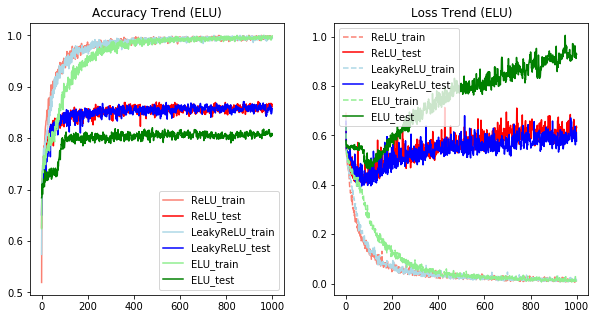

In [88]:
## EEGnet 
historys, model_names = [], []
for activation_name in ['ReLU', 'LeakyReLU', 'ELU']:
    net, train_loader, num_epochs, optimizer, criterion, test_loader = prepare_net(
        EEGNet, activation_name, optimizer_name, lr, batch_size, num_epochs)
    history = train_network(net, train_loader, num_epochs, optimizer, criterion, test_loader)
    historys.append(history)
    model_names.append(net.get_activation_name())
    
plot_historys(historys, model_names)

# current-best : 1000 epochs, SGD with lr=0.01

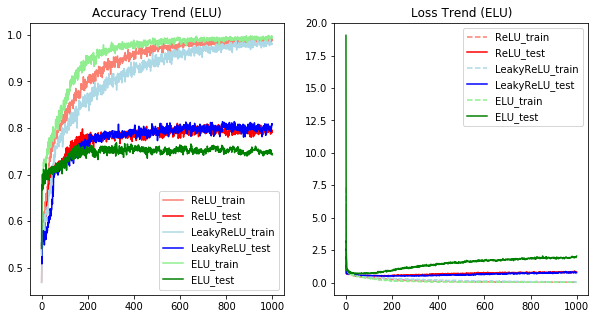

In [89]:
## DeepConvNet
historys, model_names = [], []
for activation_name in ['ReLU', 'LeakyReLU', 'ELU']:
    net, train_loader, num_epochs, optimizer, criterion, test_loader = prepare_net(
        DeepConvNet, activation_name, optimizer_name, lr, batch_size, num_epochs)
    history = train_network(net, train_loader, num_epochs, optimizer, criterion, test_loader)
    historys.append(history)
    model_names.append(net.get_activation_name())

plot_historys(historys, model_names)

In [16]:
# test plot history
def plot_historys(historys, model_names, title=""):
    plt.figure(figsize=(10,5))
    colors = [('salmon', 'red') , ('lightblue', 'blue'), ('lightgreen', 'green')]
#     plt.subplot(1,2,1)
    for i, (history, model_name) in enumerate(zip(historys, model_names)):
        plt.plot(history['train_acc'], label='%s_train'%model_name, linestyle='dashed', c=colors[i][0])
        plt.plot(history['val_acc'], label='%s_test'%model_name, c=colors[i][1])
        plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('# Epochs')
    plt.ylabel('Accuracy')
#     plt.subplot(1,2,2)
#     for i, (history, model_name) in enumerate(zip(historys, model_names)):
#         plt.plot(history['train_loss'], label='%s_train'%model_name, linestyle='dashed', c=colors[i][0])
#         plt.plot(history['val_loss'], label='%s_test'%model_name, c=colors[i][1])
#         plt.title("Loss")

# Different Dropout ratio

0.8527777777777777


0.8805555555555555


0.8472222222222222


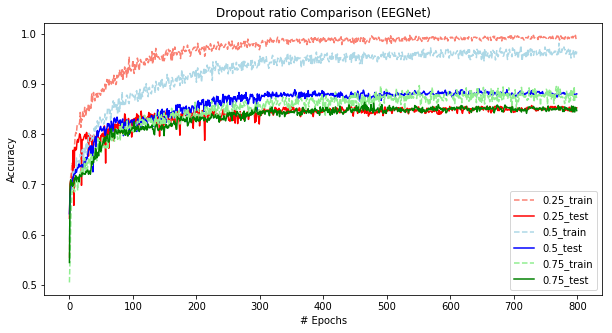

0.8481481481481481


0.8657407407407407


0.8537037037037037


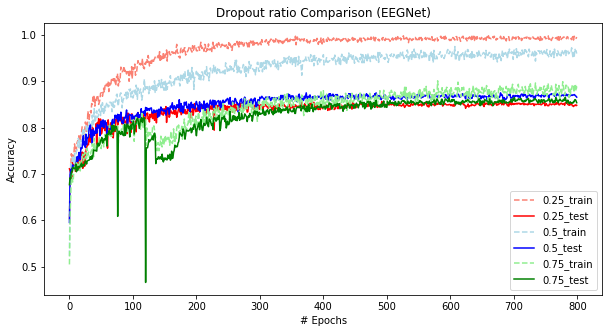

0.8648148148148148


0.8694444444444445


0.8564814814814815


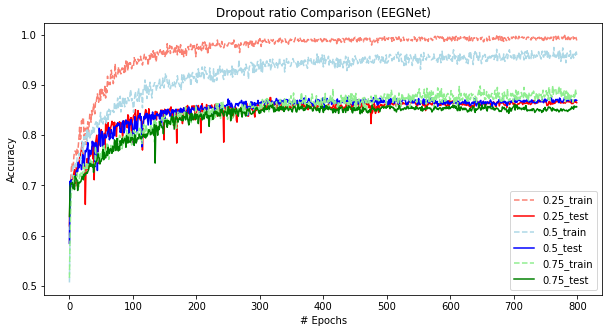

0.85


0.8731481481481481


0.8592592592592593


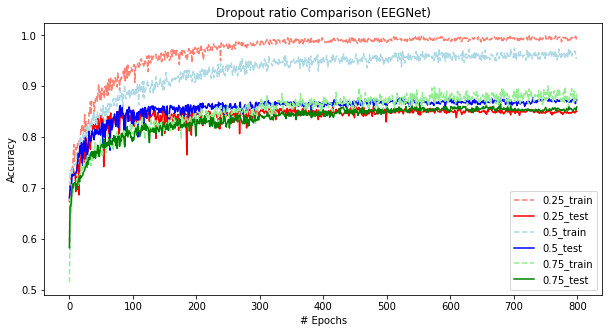

0.8537037037037037


0.8722222222222222


0.8648148148148148


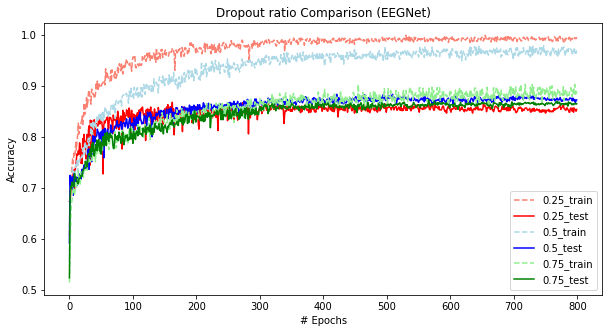

In [19]:
for N in range(5):
    historys, model_names = [], []
    for p in [0.25, 0.5, 0.75]:
        net = EEGNet(activation_name='ReLU', dropout_ratio=p)
        net = net.to(device)

        num_epochs = 800
        batch_size = 128
        lr = 0.1
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5) # SGD
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300, 500, 700], gamma=0.5)

        # Train Loader
        train_dataset = EEGDataset(train=True)
        train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle=True)

        # Test Loader
        test_dataset = EEGDataset(train=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        history = train_network(net, train_loader, num_epochs, optimizer, criterion, scheduler, test_loader)

        historys.append(history)
        model_names.append(str(p))
        print(compute_test_accuracy(net, test_data, test_label))
    title = "Dropout ratio Comparison (EEGNet)"
    plot_historys(historys, model_names, title=title)
    plt.show()

# Different Activation Functions

ReLU
0.8916666666666667


LeakyReLU
0.8592592592592593


ELU
0.8212962962962963


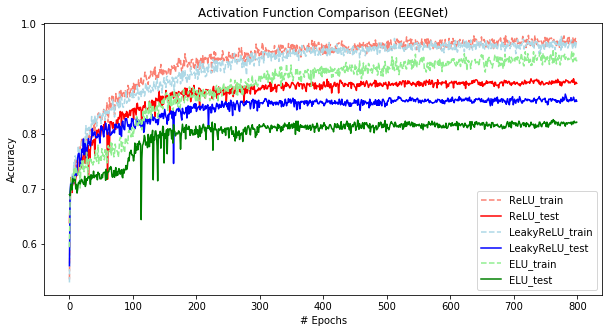

ReLU
0.862037037037037


LeakyReLU
0.8814814814814815


ELU
0.8305555555555556


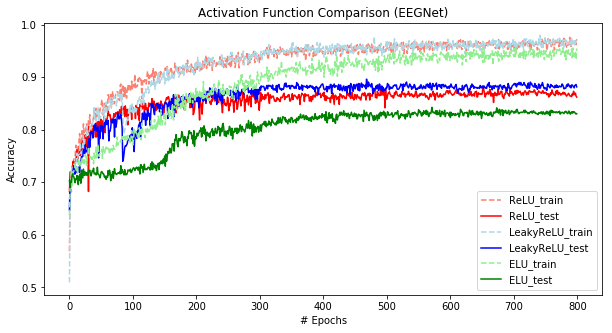

ReLU
0.8740740740740741


LeakyReLU
0.8814814814814815


ELU
0.837037037037037


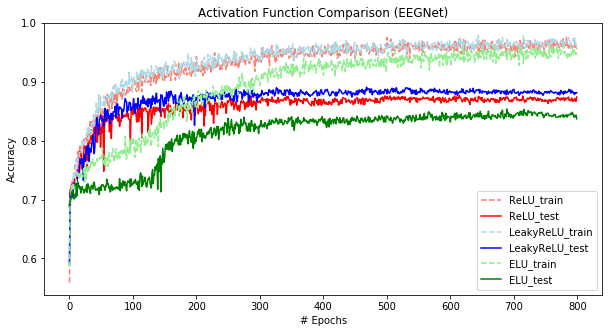

ReLU
0.8731481481481481


LeakyReLU
0.8787037037037037


ELU
0.8351851851851851


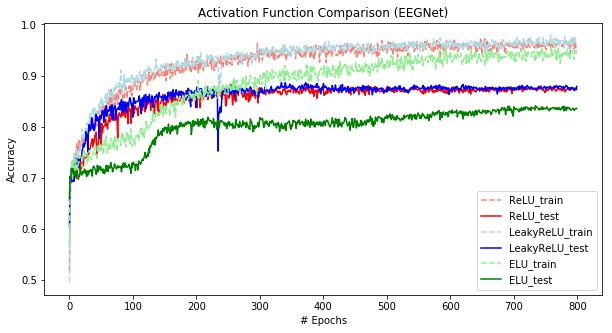

ReLU
0.8694444444444445


LeakyReLU
0.8657407407407407


ELU
0.8055555555555556


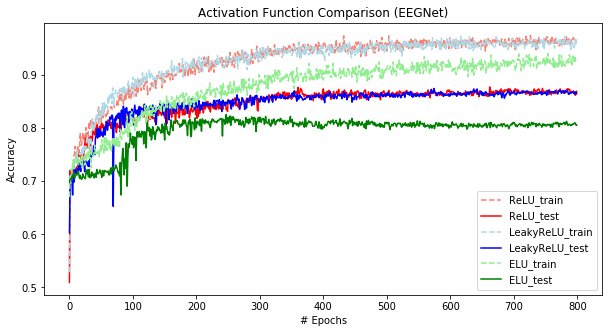

In [20]:
for N in range(5):
    historys, model_names = [], []
    for activation_name in ['ReLU', 'LeakyReLU', 'ELU']:
        net = EEGNet(activation_name=activation_name, dropout_ratio=0.5)
        net = net.to(device)

        num_epochs = 800
        batch_size = 128
        lr = 0.1
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5) # SGD
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300, 500, 700], gamma=0.5)

        # Train Loader
        train_dataset = EEGDataset(train=True)
        train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle=True)

        # Test Loader
        test_dataset = EEGDataset(train=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        history = train_network(net, train_loader, num_epochs, optimizer, criterion, scheduler, test_loader)

        historys.append(history)
        model_names.append(net.get_activation_name())
        print(activation_name)
        print(compute_test_accuracy(net, test_data, test_label))
    title = "Activation Function Comparison (EEGNet)"
    plot_historys(historys, model_names, title=title)
    plt.show()

In [ ]:
net = None

ReLU 0.5
0.8037037037037037


LeakyReLU 0.5
0.774074074074074


ELU 0.5
0.7944444444444444


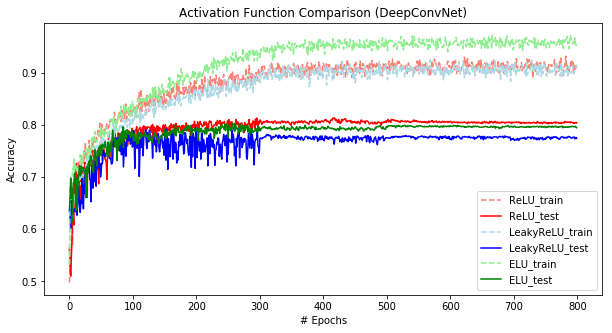

ReLU 0.5
0.8194444444444444


LeakyReLU 0.5
0.7833333333333333


ELU 0.5
0.8


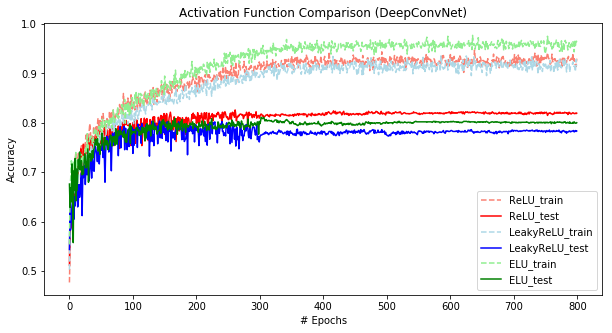

ReLU 0.5
0.7722222222222223


LeakyReLU 0.5
0.774074074074074


ELU 0.5
0.7527777777777778


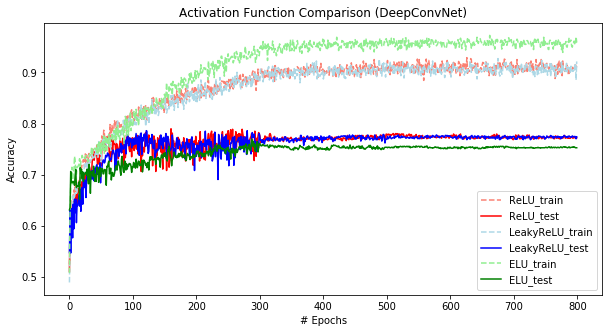

ReLU 0.5
0.7703703703703704


LeakyReLU 0.5
0.7916666666666666


ELU 0.5
0.8027777777777778


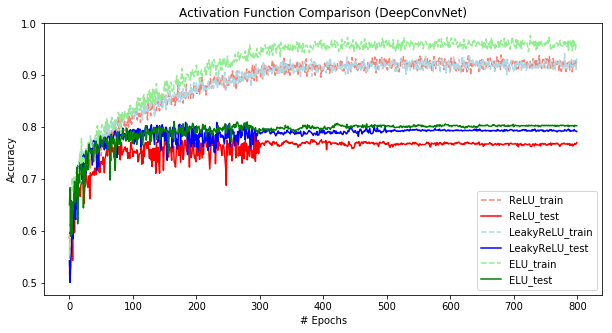

ReLU 0.5
0.8083333333333333


LeakyReLU 0.5
0.799074074074074


ELU 0.5
0.7935185185185185


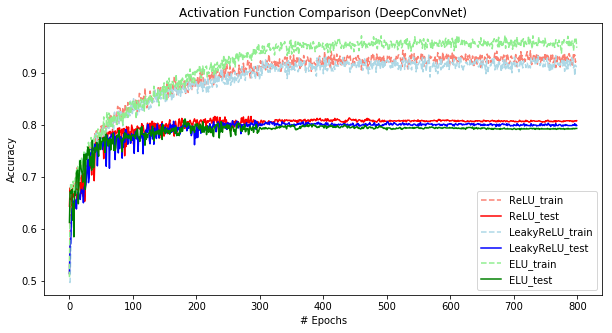

In [21]:
for N in range(5):
    historys, model_names = [], []
    p = 0.5
    for activation_name in ['ReLU', 'LeakyReLU', 'ELU']:
        net = DeepConvNet(activation_name=activation_name, dropout_ratio=p)
        net = net.to(device)

        num_epochs = 800
        batch_size = 128
        lr = 0.05
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5) # SGD
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300, 500, 700], gamma=0.1)

        # Train Loader
        train_dataset = EEGDataset(train=True)
        train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=batch_size, shuffle=True)

        # Test Loader
        test_dataset = EEGDataset(train=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.CrossEntropyLoss()
        history = train_network(net, train_loader, num_epochs, optimizer, criterion, scheduler, test_loader)

        historys.append(history)
        model_names.append(net.get_activation_name())
        print(activation_name, p)
        print(compute_test_accuracy(net, test_data, test_label))
    title = "Activation Function Comparison (DeepConvNet)"
    plot_historys(historys, model_names, title=title)
    plt.show()